<font family="Gills sans"> Dynamic synapsis in a neural network using a synaptic depression model.

This method shown in the code is applied only to a single hidden layer network. However, the plasticity effect will not be visible in the 
performance of the network unless it is applied to a multilayer network with more optimised architecture. The idea is to show how a simplified weight/gradient depression could work in a neural network. 

<The depression model is adapted from Paul Miller, An Introductory Course in Computational Neuroscience, MIT Press, 2019> </font>

In [90]:
import numpy as np
import math as math

In [91]:
class Neuron(object):
    
    def __init__(self, X, W):
        self.weights = np.array(W)
        self.inputs = np.array(X)
        self.bias= 0.1
        self.learning_rate = 0.1
        
        #adam paramerters
        self.beta1 = 0.09
        self.beta2 = 0.09
        self.eps = 1e-8
        self.m = 0
        self.v = 0
        
        #RMSProp paramerters
        self.cache = 0
        self.decay_rate = 0.9
        
        self.dw = 0
        self.dx= 0

        #Synaptic depression parameters
        # D: Depression rate
        # F: Facilitaiton rate
        # p_0: inital tranmission probability 
        # output = output - output * (p_0 * F * D)
        # D = D + p_0 * F * D
        # F = F - F_fac (f_max - F)  // f_fac and f_max are constants 
        
        #Synaptic intial vescile tranmission probability - fixed parameter
        self.p_0 = 0.5
        
        #Synaptic max facilitaiton factor- fixed parameter
        self.f_max = 4
        
        #Synaptic depression rate- will change over the operaiton
        self.D = 0.1
        
        #intial synaptic depression rate
        self.D_init = 0.1
        
        #Synaptic depression facilitation parameter- will change
        self.F = 3
        
        #Synaptic facilitaiton depression parameter- to keep the original value
        self.F_init = 3
        #Synaptic facilitaiton factor - fixed paramter
        self.F_fac = 0.2
        
        #number of iterations that a round of depression will stay on and after that will reset
        # tau_d for depression and tau_f for facilitaiton in case if they follow a different cycle; 
        # here they follow the same cycle
        self.tau_d = 5
        self.tau_f = 5
        self.tau_counter = 0

        self.out_history_init = 0 #output history intial variable;
        self.default_threshold = 0.3
        self.out_history = 0 #output history; the calculated value

        #treshold to decide when to apply depression to output; 0.75 is based on a sigmoid output 
        self.dep_threshold = self.out_history_init
        

        self.depression_mode = 0

        
    
    def activation_funciton(self, input_sum, type='sigmoid'):
        if type == 'sigmoid':
            return 1.0 / (1.0 + math.exp(-input_sum))
        
    
    def sigmoid_derivative(self, output):
        return output*(1-output)
    
    def forward(self, inputs):
        input_sum = np.sum(inputs * self.weights) + self.bias
        output = self.activation_funciton(input_sum, type='sigmoid')
        return output
        
    
    def forward_with_depression(self, inputs):
        input_sum = np.sum(inputs * self.weights) + self.bias
        output = self.activation_funciton(input_sum, type='sigmoid')
        
        if self.tau_counter >= self.tau_d:
            self.tau_counter = 0
            self.depression_mode = 0
            self.D = self.D_init
            self.F = self.F_init

        if (output >= self.dep_threshold) and (self.tau_counter < self.tau_d):
            output = output - output * (self.p_0 * self.F * self.D)
            self.depression_mode = 1
        
        self.D = self.D + self.p_0 * self.F * self.D
        if self.D > 1:
            self.D = self.D_init
        
        self.F = self.F - self.F_fac * (self.f_max - self.F)
        
        if self.F < 1:
            self.F = self.F_init

        
        self.tau_counter = self.tau_counter +1

        return output
    
    def backpropagation(self, output, actual_data, act_type='sigmoid'):
        if act_type == 'sigmoid':
            prediction_der = 2 * (output - actual_data)
            layer_der = self.sigmoid_derivative(output)
            db = prediction_der*layer_der
            dw = prediction_der * layer_der * self.inputs
            self.dw = dw
            self.db = db
            return dw, db
            
            
        
    def L2_loss(self, output, actual_output):
        l2 = (output- actual_output)**2
        l2 = np.sqrt(l2)
        return l2
    
    def train(self, grad='sgd'):
        if grad == 'sgd':
            self.weights = self.weights - self.learning_rate * self.dw
        
        if grad == 'adam':
            self.m = self.beta1 * self.m + (1 - self.beta1) * self.dw
            self.v = self.beta2 * self.v + (1 - self.beta2) * (self.dw**2)
            self.weights += - self.learning_rate * self.m / (np.sqrt(self.v) + self.eps)
        
        if grad == 'RMSprop':
            self.cache = self.decay_rate * self.cache + (1 - self.decay_rate) * self.dw**2
            self.weights += - self.learning_rate * self.dw / (np.sqrt(self.cache) + self.eps)
        
        if grad == 'adagrad':
            self.cache += self.dw**2
            self.weights += - self.learning_rate * self.dw / (np.sqrt(self.cache) + self.eps)
    

In [57]:
X = [1,2,3]
W = [0.2, 0.5, 0.9]
y = np.array([1.2])
n = Neuron(X, W)

In [58]:
out = n.forward(n.inputs)

In [92]:
X = [1,2,3]
W = [0.2, 0.5, 0.9]
y = np.array([0.2])

n = Neuron(X, W)

#for debufginng
out_array = np.zeros(300)
loss_array = np.zeros(300)
D_array = np.zeros(300)
F_array = np.zeros(300)
mode_array = np.zeros(300)
dcounter_array = np.zeros(300)
dthreshold_array = np.zeros(300)


for i in range (1, 300):
    out = n.forward_with_depression(n.inputs)
    n.backpropagation(out,y)
    n.train(grad='adagrad')
    loss=n.L2_loss(out, y)

    if (i % n.tau_d !=0):
         n.out_history = out + n.out_history
         n.dep_threshold = n.out_history / (i % n.tau_d)
         n.dep_threshold = np.maximum(n.dep_threshold,n.default_threshold)
         dthreshold_array[i] = n.dep_threshold

    else:
        n.out_history = n.out_history_init
        n.dep_threshold = n.default_threshold
        dthreshold_array[i] = n.dep_threshold


    #for debugging
    out_array[i] = out
    loss_array[i] = loss
    D_array[i] = n.D
    F_array[i] = n.F
    mode_array[i] = n.depression_mode
    dcounter_array[i] = n.tau_counter

    if (i % 30 == 0):
        print ('-*' *32)
        print('Loss')
        print(loss)
        print ('Weights', n.weights)
        print('Depression rate', n.D)
        print('Facilitation rate', n.F)
        print('Depression mode on?', n.depression_mode)
        print('How many depression applied?', n.tau_counter)

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Loss
[0.13469686]
Weights [-0.52739738 -0.22739739  0.17260261]
Depression rate 0.41933951999999985
Facilitation rate 1.511679999999999
Depression mode on? 1
How many depression applied? 5
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Loss
[0.04069903]
Weights [-0.60737525 -0.30737526  0.09262474]
Depression rate 0.41933951999999985
Facilitation rate 1.511679999999999
Depression mode on? 1
How many depression applied? 5
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Loss
[0.02118154]
Weights [-0.67739025 -0.37739026  0.02260973]
Depression rate 0.41933951999999985
Facilitation rate 1.511679999999999
Depression mode on? 0
How many depression applied? 5
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Loss
[0.00577845]
Weights [-0.69199959 -0.3919996   0.00800039]
Depression rate 0.41933951999999985
Facilitation rate 1.511679999999999
Depression mode on? 0
How many depres

In [78]:
X = [1,2,3]
W = [0.2, 0.5, 0.9]
y = np.array([0.2])
n = Neuron(X, W)

for i in range (1, 300):
    out = n.forward(n.inputs)
    n.backpropagation(out,y)
    n.train(grad='adagrad')
    loss=n.L2_loss(out, y)
    if (i % 30 == 0):
        print ('-*' *32)
        print('Loss')
        print(loss)
        print ('Weights', n.weights)

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Loss
[0.0395756]
Weights [-0.66176516 -0.3617652   0.03823478]
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Loss
[0.00572961]
Weights [-0.69214674 -0.39214678  0.00785321]
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Loss
[0.00100556]
Weights [-0.69672825 -0.39672829  0.00327169]
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Loss
[0.0001818]
Weights [-0.69753684 -0.39753688  0.0024631 ]
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Loss
[3.30409922e-05]
Weights [-0.69768317 -0.39768321  0.00231677]
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Loss
[6.01078444e-06]
Weights [-0.69770977 -0.39770981  0.00229018]
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Loss
[1.09366521e-06]
Weights [-0.69771461 -0.39771465  0.00228534]
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Loss
[1.98999194e-07]


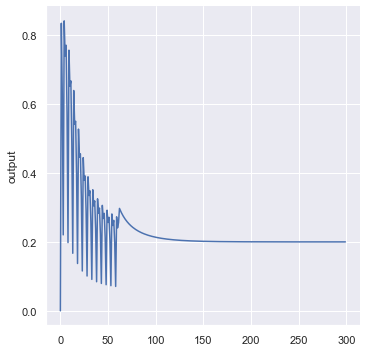

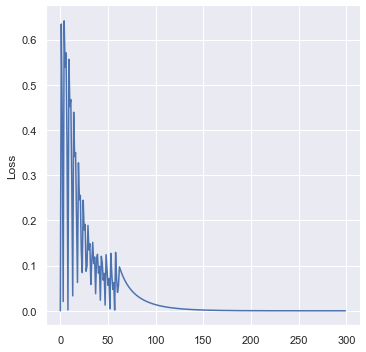

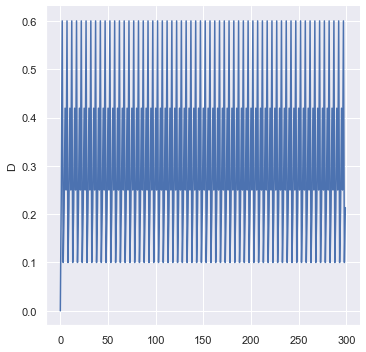

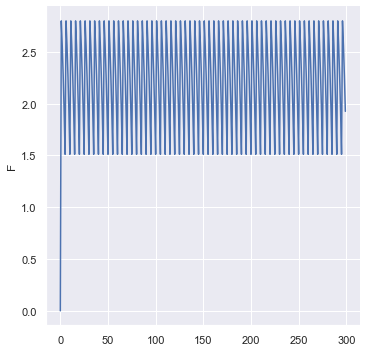

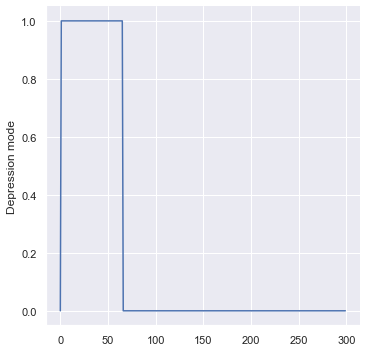

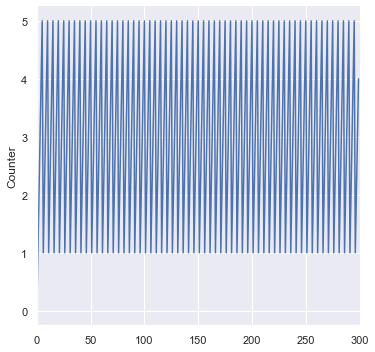

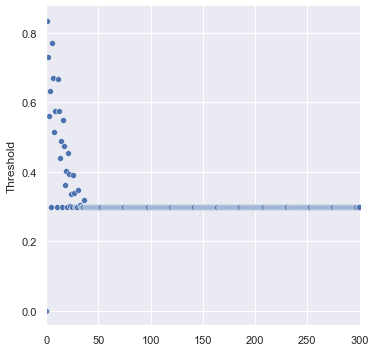

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')
%matplotlib inline

x1 = np.arange(0,300)
y1 = np.arange(1,5)
ax1 = sns.relplot(kind='line', data=out_array)
ax1.set_ylabels(label='output')

ax2 = sns.relplot(kind='line', data=loss_array)
ax2.set_ylabels(label='Loss')

ax3= sns.relplot(kind='line', data=D_array)
ax3.set_ylabels(label='D')

ax4= sns.relplot(kind='line', data=F_array)
ax4.set_ylabels(label='F')

ax5= sns.relplot(kind='line', data=mode_array)
ax5.set_ylabels(label='Depression mode')


ax6 = sns.relplot(data=dcounter_array, kind='line')
ax6.set(xlim=(0,300))
ax6.set_ylabels(label='Counter')

ax7 = sns.relplot(data=dthreshold_array, kind='scatter')
ax7.set(xlim=(0,300))
ax7.set_ylabels(label='Threshold')
